In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, confusion_matrix

# ===================== 自定义颜色 =====================
custom_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a"
]

# ===================== 数据读取与预处理 =====================
df = pd.read_csv("../data/data-923.csv")
cols = [f"en{i}" for i in range(1,16)]
X = df[cols].values
y_raw = df["cate"].astype(str).values
le = LabelEncoder()
y = le.fit_transform(y_raw)
class_names = le.classes_
n_classes = len(class_names)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_y_true, all_y_pred, all_y_prob = [], [], []

for train_idx, test_idx in kf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    lda = LinearDiscriminantAnalysis(n_components=n_classes-1)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)

    model = GaussianNB()
    model.fit(X_train_lda, y_train)
    y_pred = model.predict(X_test_lda)
    print(X_test_lda.shape)
    y_prob = model.predict_proba(X_test_lda)

    all_y_true.append(y_test)
    all_y_pred.append(y_pred)
    all_y_prob.append(y_prob)

y_true_all = np.concatenate(all_y_true)
y_pred_all = np.concatenate(all_y_pred)
y_prob_all = np.concatenate(all_y_prob)




(16, 12)
(16, 12)
(16, 12)
(15, 12)
(15, 12)


In [5]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis()),
    ('nb', GaussianNB())
])
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    pipe, X, y,
    cv=StratifiedKFold(5, shuffle=True, random_state=42)
)

print(scores)
print(scores.mean(), scores.std())

[1. 1. 1. 1. 1.]
1.0 0.0


In [6]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
from sklearn.model_selection import permutation_test_score

score, perm_scores, pvalue = permutation_test_score(
    pipe, X, y,
    cv=5,
    n_permutations=1000
)

print("P-value:", pvalue)


P-value: 0.000999000999000999


In [7]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import permutation_test_score


# ===================== 数据读取 =====================
df = pd.read_csv("../data/data-923.csv")

cols = [f"en{i}" for i in range(1, 16)]
X = df[cols].values
y_raw = df["cate"].astype(str).values

# 标签编码
le = LabelEncoder()
y = le.fit_transform(y_raw)


# ===================== 构建 Pipeline（防信息泄漏） =====================
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis()),
    ("nb", GaussianNB())
])


# ===================== 分层5折交叉验证 =====================
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)


# ===================== 交叉验证准确率 =====================
scores = cross_val_score(
    pipe,
    X,
    y,
    cv=cv,
    scoring="accuracy"
)

print("Cross-validation accuracy for each fold:")
print(scores)

print(f"\nMean Accuracy: {scores.mean():.4f}")
print(f"Std Accuracy:  {scores.std():.4f}")


# ===================== Permutation Test（可选但推荐） =====================
score, perm_scores, pvalue = permutation_test_score(
    pipe,
    X,
    y,
    cv=cv,
    n_permutations=1000,
    n_jobs=-1,
    random_state=42
)

print("\nPermutation Test Result:")
print(f"Original Score: {score:.4f}")
print(f"P-value:        {pvalue:.6f}")


Cross-validation accuracy for each fold:
[1. 1. 1. 1. 1.]

Mean Accuracy: 1.0000
Std Accuracy:  0.0000

Permutation Test Result:
Original Score: 1.0000
P-value:        0.000999


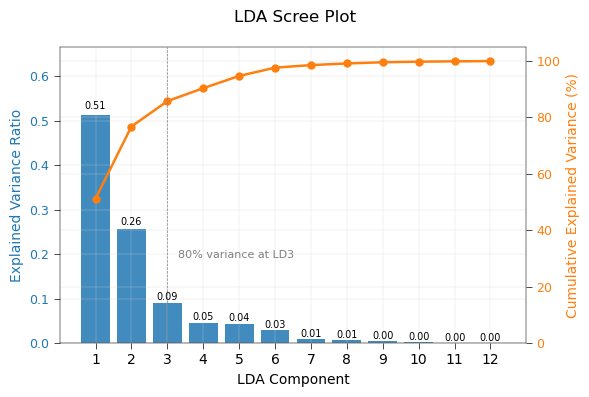

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 explained_var 和 cum_var 已经由 LDA fit 得到
explained_var = lda.explained_variance_ratio_
cum_var = np.cumsum(explained_var)
ld_indices = np.arange(1, len(explained_var)+1)

fig, ax1 = plt.subplots(figsize=(6,4))

# ------------------- 左轴：柱状图 -------------------
bars = ax1.bar(ld_indices, explained_var, color="#1f77b4", alpha=0.85,
               edgecolor='k', linewidth=0, label="Individual LD")
ax1.set_xlabel("LDA Component", fontsize=10)
ax1.set_ylabel("Explained Variance Ratio", fontsize=10, color="#1f77b4")
ax1.tick_params(axis='y', labelcolor="#1f77b4", labelsize=9, width=0.5, length=4)
ax1.tick_params(axis='x', width=0.5, length=4)
ax1.set_xticks(ld_indices)
ax1.set_ylim(0, max(explained_var)*1.3)

# 柱顶标注每个 LD 的贡献率
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., 1.02*height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=7)

# ------------------- 右轴：累计折线 -------------------
ax2 = ax1.twinx()
ax2.plot(ld_indices, cum_var*100, color="#ff7f0e", marker='o', markersize=5,
         linewidth=1.8, label="Cumulative Explained")
ax2.set_ylabel("Cumulative Explained Variance (%)", fontsize=10, color="#ff7f0e")
ax2.tick_params(axis='y', labelcolor="#ff7f0e", labelsize=9, width=0.5, length=4)
ax2.set_ylim(0, 105)

# 标注达到80%累计解释率的LD
threshold = 80
first_above = np.where(cum_var*100 >= threshold)[0][0] + 1
ax2.axvline(x=first_above, color='grey', linestyle='--', linewidth=0.5)
ax2.text(first_above+0.3, 30, f'{threshold}% variance at LD{first_above}',
         color='grey', fontsize=8)

# ------------------- 坐标轴极细 -------------------
for spine in ax1.spines.values():
    spine.set_linewidth(0.2)
for spine in ax2.spines.values():
    spine.set_linewidth(0.2)

ax1.grid(
         linestyle='-', 
         alpha=0.7, 
         color='lightgray', 
         linewidth=0.3)
ax2.grid(
         linestyle='-', 
         alpha=0.7, 
         color='lightgray', 
         linewidth=0.3)
# ------------------- 网格和美化 -------------------
fig.suptitle("LDA Scree Plot", fontsize=12)
fig.tight_layout()

# ------------------- 高精度输出 -------------------
plt.savefig("Fig2a_LDA_scree_Nature_Final.pdf", dpi=300)
plt.show()
